 # QC analysis of single cell RNA-seq dataset: This notebook will guide you through the process of quality control analyis on a single-cell RNA sequencing dataset

#### Please insert your inputs

In [1]:
#DSID = 'DS000013902'   # the dataset Id based on what you received when you submitted your dataset
#DEV = False    # A boolean based on whether your dataset saved to the dev server
#organism = 'human' # human or mouse
#groupby = f'Sample' # 
#min_cells = 3
#min_genes = 500
#max_genes = None
#pct_mt = None
#total_counts = None
#ribo = True
#doublets = True # This refers to hashing. Only for hashing when you have demux_type in obs
#title = "Siavash test upload"  # title for the experiment
#description = "Siavash test upload; this should be gone"  # description for the experiment
#name_space = [{"id": "GRCh38", "type": "genome"}]   # genome information
#sources = [{"id": "Siavash-1234", "name": "Geo-ID"}] # any identifiers you want to attach to the experiment, usually GEO ids, publication etc.
#tech_name = "scRNA-seq" # technology name; this is a controlled vocabulary
#author = "SG"   #Authors names

In [9]:
# Different scenario for original dataset or test dataset
if DS_test==False:
    DSID = DatasetID
    Version = '2'   # the version of your dataset
else:
    DSID = test_DatasetID
    Version = '2'   # the version of your dataset
    DEV = True
your_experiment = "crispr_hashing_harmonized" # A string that is a key known for our desired experimnet that you wish to work on
New_experiment = "raw_qc" # A string that is a key known for the updated data saved by that that name

In [10]:
## Import Libraries

from __future__ import division
%matplotlib inline 

#single cell libraries
import scanpy as sc
import anndata
from harmony import harmonize

#general
import pandas as pd
import sys, os
import numpy as np
import scipy
from scipy import stats
import itertools
from glob import glob
import warnings
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)
from collections import OrderedDict 
from scipy.stats import zscore

#plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [4]:
#import sys
#sys.path.append("..")
from Templates.tools import *

/apps/user/gpy/envs/dev/GPy39/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/apps/user/gpy/envs/dev/GPy39/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/apps/user/gpy/envs/dev/GPy39/lib/python3.9/site-packages/umap/distances.py:1086: 

In [12]:
%load_ext autoreload
%autoreload 2

## Instantiate a dataset object given our dataset info

In [13]:
DS = DB.DATASET(DSID, DEV, title=title, description=description, name_space=name_space, organism=organism,
                       sources=sources, tech_name=tech_name, author=author)

In [14]:
adata, adatas = DS.load_dataset(Version, your_experiment)


13:58:44 -> Collating dataset: 'DS000013902' metadata.

13:58:44 -> Reading: 'DS000013902'.

13:58:44 -> Reading: 'DS000013902 -> Experiment: main'.

13:58:44 -> Reading: 'DS000013902 -> Experiment: main -> Alt. Exp.: crispr'.

13:58:44 -> Reading: 'DS000013902 -> Experiment: main -> Alt. Exp.: hashing'.


In [16]:
adata = rnaqc.load_data(adata)

In [17]:
adata.obs.head()

,Sample,Barcode,demux_type,assignment
SAM24424070_Replicate1-AAACCCAAGACGTCGA-1,SAM24424070_Replicate1,AAACCCAAGACGTCGA-1,singlet,DLD1-infected-not-transfected
SAM24424070_Replicate1-AAACCCAAGAGATTCA-1,SAM24424070_Replicate1,AAACCCAAGAGATTCA-1,singlet,DLD1-infected-not-transfected
SAM24424070_Replicate1-AAACCCAAGCCAGACA-1,SAM24424070_Replicate1,AAACCCAAGCCAGACA-1,singlet,DLD1-infected-not-transfected
SAM24424070_Replicate1-AAACCCAAGCGATGCA-1,SAM24424070_Replicate1,AAACCCAAGCGATGCA-1,singlet,DLD1-infected-not-transfected
SAM24424070_Replicate1-AAACCCAAGGATATGT-1,SAM24424070_Replicate1,AAACCCAAGGATATGT-1,singlet,DLD1-infected-not-transfected


### Sumarize counts

In [18]:
cnts_before = rnaqc.Summerize_counts(adata, groupby)

In [19]:
cnts_before

,cnt,pct
Sample,,
SAM24424070_Replicate1,18270,100.0
SAM24424071_Replicate1,18801,100.0


### calculate qc metrics

In [20]:
adata = proc.calc_qc_metrics(adata, organism)

In [21]:
LOWER,UPPER = rnaqc.upper_lower_limits(adata, groupby)

In [22]:
LOWER

,n_genes_by_counts,total_counts,pct_counts_mt,pct_counts_ribo
SAM24424070_Replicate1,-59.0,-1381.625,-0.021260,14.185107
SAM24424071_Replicate1,-106.5,-1838.500,0.354149,15.314071


In [23]:
UPPER

,n_genes_by_counts,total_counts,pct_counts_mt,pct_counts_ribo
SAM24424070_Replicate1,4101.0,11281.375,13.433825,37.846055
SAM24424071_Replicate1,4169.5,12005.500,12.656575,37.024222


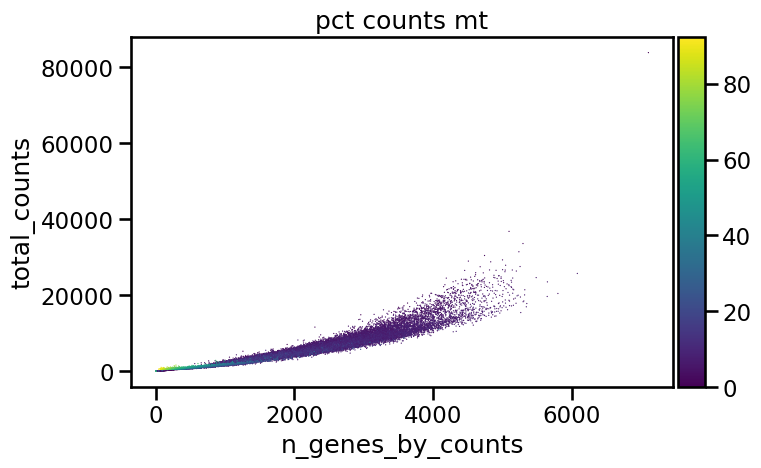

In [24]:
sc.pl.scatter(adata, 'n_genes_by_counts', 'total_counts', color='pct_counts_mt') 

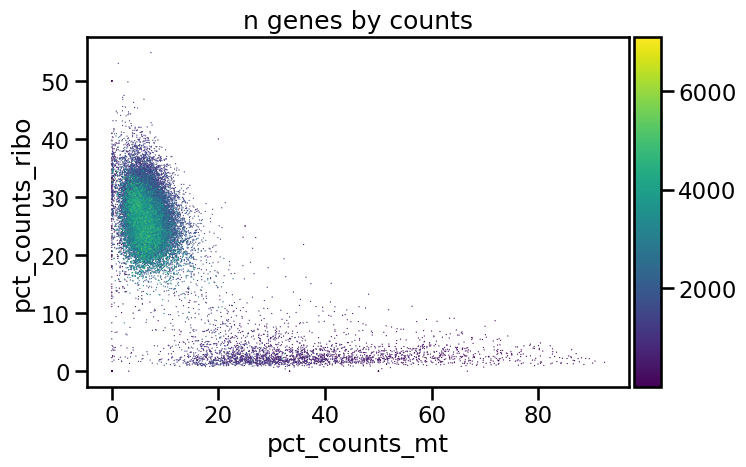

In [25]:
sc.pl.scatter(adata, 'pct_counts_mt', 'pct_counts_ribo', color='n_genes_by_counts')

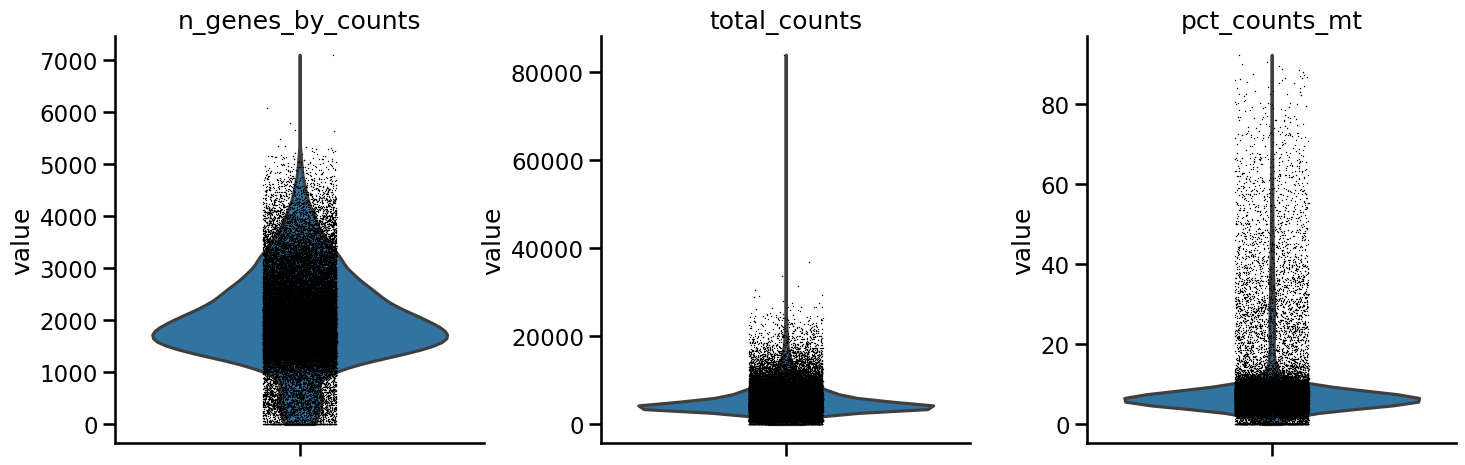

In [26]:
sc.pl.violin(
    adata, 
    [
     'n_genes_by_counts', 
     'total_counts', 
     'pct_counts_mt'
     ],
    multi_panel=True
)

In [27]:
aggr = rnaqc.aggregation(adata, groupby, None, 'before')

In [28]:
aggr

,Sample,variable,value,step
0,SAM24424070_Replicate1,n_genes_by_counts,2083.000000,before
1,SAM24424070_Replicate1,n_genes_by_counts,1941.000000,before
2,SAM24424070_Replicate1,n_genes_by_counts,1523.000000,before
3,SAM24424070_Replicate1,n_genes_by_counts,2240.000000,before
4,SAM24424070_Replicate1,n_genes_by_counts,818.000000,before
...,...,...,...,...
148279,SAM24424071_Replicate1,pct_counts_ribo,25.221987,before
148280,SAM24424071_Replicate1,pct_counts_ribo,29.517698,before
148281,SAM24424071_Replicate1,pct_counts_ribo,29.920761,before
148282,SAM24424071_Replicate1,pct_counts_ribo,30.767897,before


## Apply filter

In [29]:
adata = proc.filter_adata(
    adata, 
    groupby, 
    min_cells, 
    min_genes, 
    ribo, 
    doublets=doublets, pct_mt=pct_mt)

starting with 37071 cells
Now 37071 cells after filtering min cells 3
Now 35420 cells after filtering min genes 500
Calculating upper outliers
Now 34680 cells after filtering max genes 
Calculating upper outliers
Now 32636 cells after filtering pct mt 
Calculating upper outliers
Now 31313 cells after filtering total counts 
Now 30863 cells after filtering pct ribo 
Now 25902 cells after keeping singlets


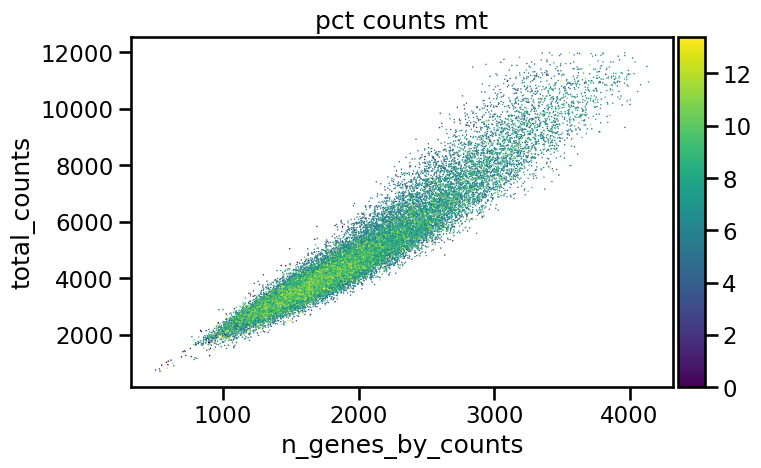

In [30]:
 sc.pl.scatter(adata, 'n_genes_by_counts', 'total_counts', color='pct_counts_mt')

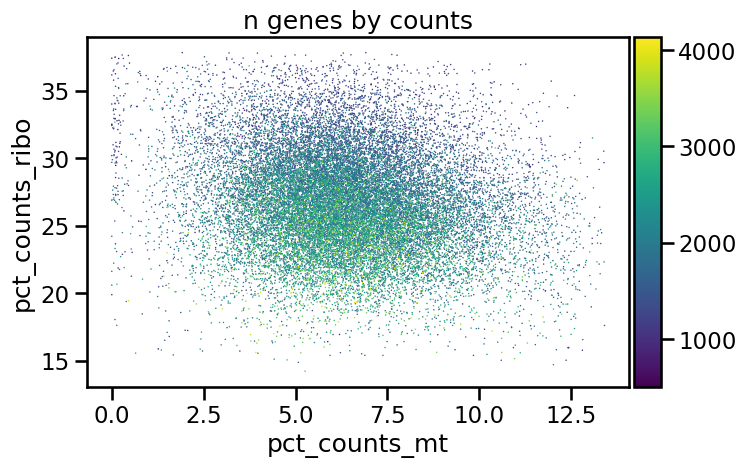

In [31]:
sc.pl.scatter(adata, 'pct_counts_mt', 'pct_counts_ribo', color='n_genes_by_counts')

In [32]:
adata.obs['pct_counts_mt']

SAM24424070_Replicate1-AAACCCAAGACGTCGA-1    3.595080
SAM24424070_Replicate1-AAACCCAAGAGATTCA-1    6.439991
SAM24424070_Replicate1-AAACCCAAGCCAGACA-1    5.020921
SAM24424070_Replicate1-AAACCCAAGCGATGCA-1    6.957404
SAM24424070_Replicate1-AAACCCAAGGATTTCC-1    8.457711
                                               ...   
SAM24424071_Replicate1-TTTGTTGTCGCCGAAC-1    2.536998
SAM24424071_Replicate1-TTTGTTGTCGCGAAGA-1    4.729870
SAM24424071_Replicate1-TTTGTTGTCGCTGTCT-1    4.754358
SAM24424071_Replicate1-TTTGTTGTCGTCACCT-1    5.139539
SAM24424071_Replicate1-TTTGTTGTCTGGGTCG-1    6.573665
Name: pct_counts_mt, Length: 25902, dtype: float64

In [33]:
aggr = rnaqc.aggregation(adata, groupby,aggr, 'after')

In [34]:
aggr

,Sample,variable,value,step
0,SAM24424070_Replicate1,n_genes_by_counts,2083.000000,before
1,SAM24424070_Replicate1,n_genes_by_counts,1941.000000,before
2,SAM24424070_Replicate1,n_genes_by_counts,1523.000000,before
3,SAM24424070_Replicate1,n_genes_by_counts,2240.000000,before
4,SAM24424070_Replicate1,n_genes_by_counts,818.000000,before
...,...,...,...,...
103603,SAM24424071_Replicate1,pct_counts_ribo,25.221987,after
103604,SAM24424071_Replicate1,pct_counts_ribo,29.517698,after
103605,SAM24424071_Replicate1,pct_counts_ribo,29.920761,after
103606,SAM24424071_Replicate1,pct_counts_ribo,30.767897,after


/gstore/home/ghaffars/Projects/automated-pipelines/scProc.py:222: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/gstore/home/ghaffars/Projects/automated-pipelines/scProc.py:222: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/gstore/home/ghaffars/Projects/automated-pipelines/scProc.py:222: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/gstore/home/ghaffars/Projects/automated-pipelines/scProc.py:222: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


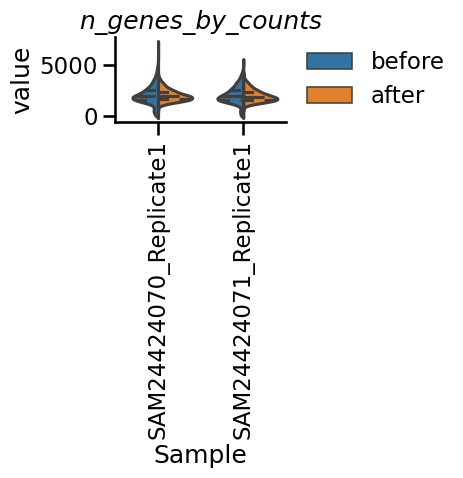

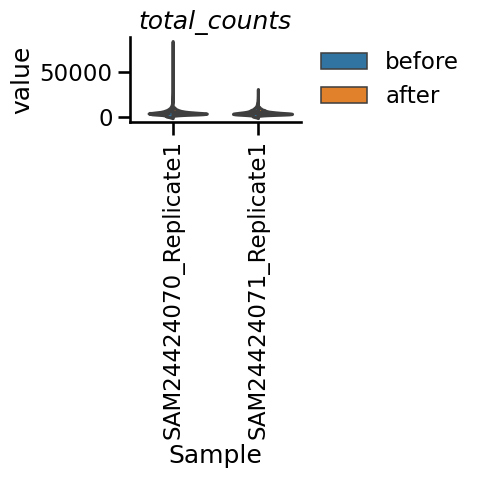

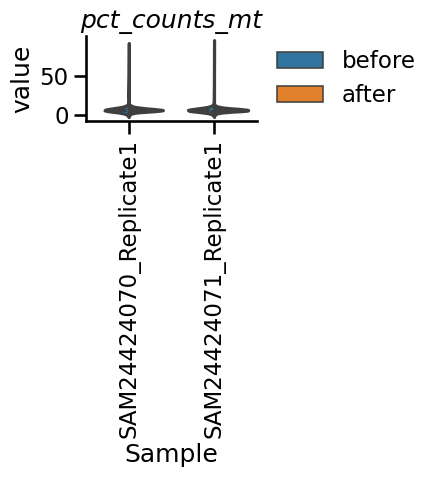

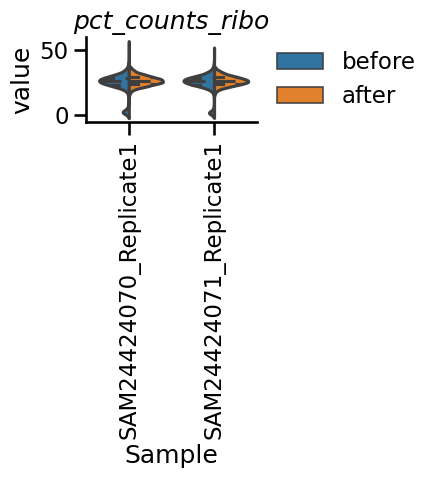

In [35]:
#QC plots before and after
for k in ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo']:
    proc.plotQCSplit(aggr, groupby, k)

In [36]:
cnts_after = rnaqc.Summerize_counts(adata,groupby)

In [37]:
cnts_after

,cnt,pct
Sample,,
SAM24424070_Replicate1,12544,100.0
SAM24424071_Replicate1,13358,100.0


In [38]:
proc.aggCnts(cnts_before, cnts_after)

,before,after,pct left
Sample,,,
SAM24424070_Replicate1,18270,12544,68.7
SAM24424071_Replicate1,18801,13358,71.0


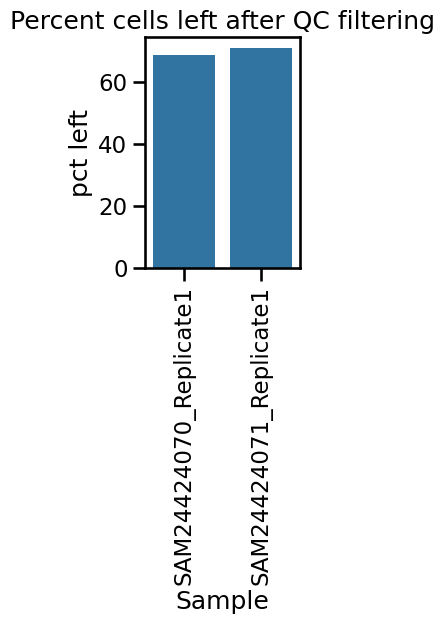

In [39]:
 proc.plot_cell_left(cnts_before, cnts_after, groupby)

In [40]:
#This is just to quickly check how the data looks. Cell cycle scores are added to main adata object, but normalized and processed object is not saved
adata_tmp = adata.copy()

adata_tmp = proc.proc(adata_tmp, 'auto', norm=True, scale=True, regress=False, embedding=True)

normalizing
selecting highly variable genes
Done selecting 1357 highly variable genes
scaling
computing PCA


/apps/user/gpy/envs/dev/GPy39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


computing UMAP


In [41]:
 # score cell cycle
if organism=='human':
    fcc =  '/gstore/data/cbfunge/data/CellCycleGenes/Homo_sapiens.csv'
elif organism == 'mouse':
    fcc = '/gstore/data/cbfunge/data/CellCycleGenes/Mus_musculus.csv'
    
proc.compute_cellCycleScores(adata_tmp, fcc)

AnnData object with n_obs × n_vars = 25902 × 26987
    obs: 'Sample', 'Barcode', 'demux_type', 'assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'ID', 'Symbol', 'Type', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '.internal', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/apps/user/gpy/envs/dev/GPy39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


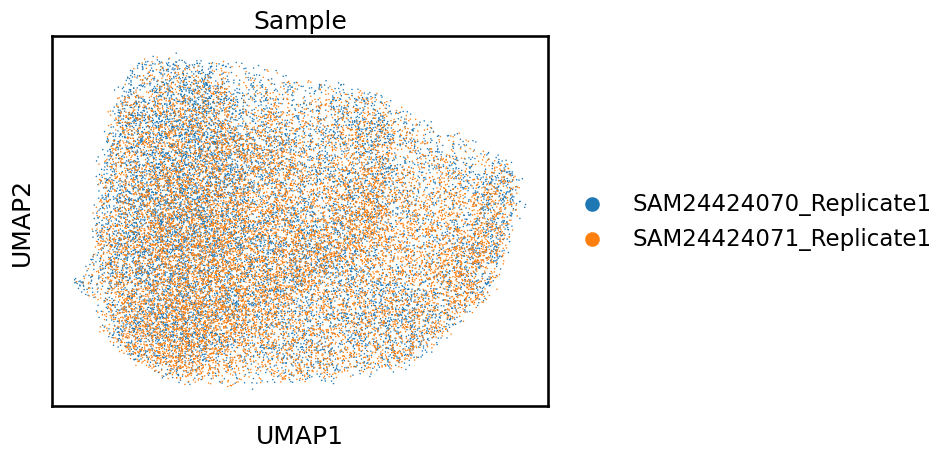

In [42]:
sc.pl.umap(adata_tmp, color=groupby)

/apps/user/gpy/envs/dev/GPy39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


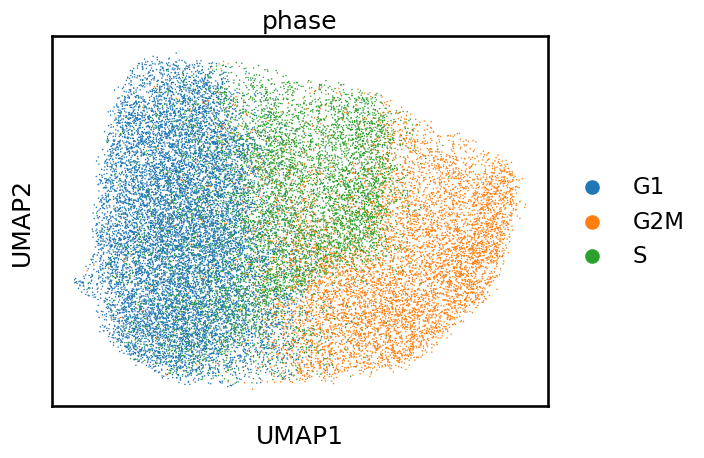

In [43]:
sc.pl.umap(adata_tmp, color='phase') 

In [44]:
#Save filtered raw data
adata.obs['phase'] = adata_tmp.obs['phase']
adata.obs['G2M_score'] = adata_tmp.obs['G2M_score']
adata.obs['S_score'] = adata_tmp.obs['S_score']

/local/2223320/ipykernel_6029/2244264157.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['phase'] = adata_tmp.obs['phase']


In [45]:
adata.obs

,Sample,Barcode,demux_type,assignment,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,phase,G2M_score,S_score
SAM24424070_Replicate1-AAACCCAAGACGTCGA-1,SAM24424070_Replicate1,AAACCCAAGACGTCGA-1,singlet,DLD1-infected-not-transfected,2083,5285,190,3.595080,1503,28.438978,2082,G1,-0.414895,-0.380382
SAM24424070_Replicate1-AAACCCAAGAGATTCA-1,SAM24424070_Replicate1,AAACCCAAGAGATTCA-1,singlet,DLD1-infected-not-transfected,1941,4441,286,6.439991,1212,27.291151,1941,G1,-0.451376,-0.286129
SAM24424070_Replicate1-AAACCCAAGCCAGACA-1,SAM24424070_Replicate1,AAACCCAAGCCAGACA-1,singlet,DLD1-infected-not-transfected,1523,3107,156,5.020921,848,27.293209,1523,G1,-0.321621,-0.238625
SAM24424070_Replicate1-AAACCCAAGCGATGCA-1,SAM24424070_Replicate1,AAACCCAAGCGATGCA-1,singlet,DLD1-infected-not-transfected,2240,4930,343,6.957404,1096,22.231237,2240,G2M,0.346869,-0.115853
SAM24424070_Replicate1-AAACCCAAGGATTTCC-1,SAM24424070_Replicate1,AAACCCAAGGATTTCC-1,singlet,DLD1-infected-not-transfected,1921,5025,425,8.457711,1450,28.855721,1921,G1,-0.532819,-0.350740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAM24424071_Replicate1-TTTGTTGTCGCCGAAC-1,SAM24424071_Replicate1,TTTGTTGTCGCCGAAC-1,singlet,DLD1-infected-transfected,1877,4730,120,2.536998,1193,25.221987,1877,S,-0.087028,0.717137
SAM24424071_Replicate1-TTTGTTGTCGCGAAGA-1,SAM24424071_Replicate1,TTTGTTGTCGCGAAGA-1,singlet,DLD1-infected-transfected,2876,9662,457,4.729870,2852,29.517698,2876,S,-0.204035,0.299149
SAM24424071_Replicate1-TTTGTTGTCGCTGTCT-1,SAM24424071_Replicate1,TTTGTTGTCGCTGTCT-1,singlet,DLD1-infected-transfected,1415,3155,150,4.754358,944,29.920761,1415,S,0.000293,0.250605
SAM24424071_Replicate1-TTTGTTGTCGTCACCT-1,SAM24424071_Replicate1,TTTGTTGTCGTCACCT-1,singlet,DLD1-infected-transfected,3169,11538,593,5.139539,3550,30.767897,3169,G1,-0.084050,-0.047390


In [46]:
adata.var

,ID,Symbol,Type,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
Symbol,,,,,,,,,,
AL627309.1,GRCh38-2020-A_ENSG00000238009,GRCh38-2020-A_AL627309.1,Gene Expression,False,False,31,0.000836,99.916377,31,31
AL627309.5,GRCh38-2020-A_ENSG00000241860,GRCh38-2020-A_AL627309.5,Gene Expression,False,False,67,0.001807,99.819266,67,67
AP006222.2,GRCh38-2020-A_ENSG00000286448,GRCh38-2020-A_AP006222.2,Gene Expression,False,False,23,0.000620,99.937957,23,23
AL732372.1,GRCh38-2020-A_ENSG00000236601,GRCh38-2020-A_AL732372.1,Gene Expression,False,False,4,0.000108,99.989210,4,4
AC114498.1,GRCh38-2020-A_ENSG00000235146,GRCh38-2020-A_AC114498.1,Gene Expression,False,False,5,0.000135,99.986512,5,5
...,...,...,...,...,...,...,...,...,...,...
AC004556.3,GRCh38-2020-A_ENSG00000276345,GRCh38-2020-A_AC004556.3,Gene Expression,False,False,55,0.001484,99.851636,55,55
AC136352.3,GRCh38-2020-A_ENSG00000277666,GRCh38-2020-A_AC136352.3,Gene Expression,False,False,15,0.000405,99.959537,15,15
AC007325.4,GRCh38-2020-A_ENSG00000278817,GRCh38-2020-A_AC007325.4,Gene Expression,False,False,434,0.011869,98.829274,440,434


In [47]:
adatas

{'crispr': AnnData object with n_obs × n_vars = 37071 × 21091
     uns: '.internal'
     layers: 'counts',
 'hashing': AnnData object with n_obs × n_vars = 37071 × 8
     uns: '.internal'
     layers: 'counts'}

In [48]:
adata_updated = adata.copy()
adatas_updated = {}

### Write h5ad version on the disk

In [ ]:
# If you wish to write on the disk
adata.var.index.name = None
adata.write_h5ad(raw_qc)

## Update the dataset with new experiment "raw_qc"

In [52]:
dsid, version = DS.update_dataset(New_experiment, adata_updated, adatas_updated, test=DS_test)


14:01:14 -> Collating dataset: 'test-DS000004576' metadata.

14:01:15 -> Reading: 'test-DS000004576'.

14:01:15 -> Reading: 'test-DS000004576 -> Experiment: main'.

14:01:15 -> Reading: 'test-DS000004576 -> Experiment: main -> Alt. Exp.: crispr'.


/apps/user/gpy/envs/dev/GPy39/lib/python3.9/site-packages/pydsdb/upload/metadata/adders.py:39: PYDSDBWarning: Experiment already contained metadata, overwriting.
  warn(


Retrieving cached token data.
Successfully authenticated.
14:01:31 -> Retrieving project: test-DS000004576@NUM-14 metadata.
14:01:34 -> Metadata cached.
14:01:34 -> Collating project resources.
14:01:34 -> Validating JSON metadata.
14:01:36 -> Attempting upload.


 76%|██████████████████████████████▎         | 72/95 [00:07<00:02, 10.12file/s]


Clearing upload info.
14:02:13 -> Upload completed.
Processing
Processing
Processing
Processing
Upload successful, your DSID is 'test-DS000004576' and version is: '15'. Also written to 'upload_info.json' in staging dir.


In [53]:
dsid, version

('test-DS000004576', '15')